In [3]:
import warnings
warnings.filterwarnings("ignore") # shut the warnings up

import numpy as np # fast mathematical operations
import pandas as pd # tabular data manipulation

import os # check the contents of working directory

import re # regular expressions

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier, LogisticRegression# tool for training linear regression
from sklearn.ensemble import RandomForestClassifier # Random Forest - ensemble of trees trained on bootstrap subsamples
                                                    # using random subsets of features
from lightgbm import LGBMClassifier # Gradient Boosting Machine - ensemble of trees, in which each new tree aims to 
                                    # minimize the loss of existing composition
from sklearn.model_selection import train_test_split, KFold # split data into train and test sets
from sklearn.model_selection import GridSearchCV # tool for hyperparameters tuning 
                                                            # with progress bar for tracking progress

from datetime import datetime as dt # working with timestamps


from matplotlib import pyplot as plt # graphs
import seaborn as sns # fancy graphs
sns.set() # allows to use pyplot and get fancy graphs

from tqdm import tqdm

In [3]:
df_train = pd.read_csv('credit_train.csv')
df_test = pd.read_csv('credit_test.csv')

In [4]:
df_train.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6,1,228190,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9,0,256329,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15,0,253460,427174.0,0.0,0.0


In [5]:
y = df_train["Loan Status"]

In [6]:
df_train["Loan Status"].value_counts() / df_train.shape[0]

Fully Paid     0.77361
Charged Off    0.22639
Name: Loan Status, dtype: float64

In [7]:
df_train.drop("Loan Status", axis=1, inplace=True)

In [8]:
df_train.shape

(100000, 18)

In [9]:
df_test.shape

(10000, 18)

In [10]:
df_test.index = range(100000, 110000)

In [11]:
df_total = pd.concat([df_train, df_test], axis=0)

In [12]:
df_total.nunique() / df_total.shape[0]

Loan ID                         0.803218
Customer ID                     0.803218
Current Loan Amount             0.204564
Term                            0.000018
Credit Score                    0.002964
Annual Income                   0.344118
Years in current job            0.000100
Home Ownership                  0.000036
Purpose                         0.000145
Monthly Debt                    0.634091
Years of Credit History         0.004609
Months since last delinquent    0.001055
Number of Open Accounts         0.000473
Number of Credit Problems       0.000127
Current Credit Balance          0.305827
Maximum Open Credit             0.422436
Bankruptcies                    0.000073
Tax Liens                       0.000118
dtype: float64

__Изучим пропуски__

In [13]:
df_total.isna().sum()

Loan ID                             0
Customer ID                         0
Current Loan Amount                 0
Term                                0
Credit Score                    21135
Annual Income                   21135
Years in current job             4649
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    58447
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 2
Bankruptcies                      226
Tax Liens                          11
dtype: int64

In [14]:
median_cla = df_total["Current Loan Amount"].median()

In [15]:
df_total["Current Loan Amount"] = df_total["Current Loan Amount"].apply(lambda x: x if x != 99999999 else median_cla)

In [16]:
df_total["no_credit_score"] = df_total["Credit Score"].apply(lambda x: int(pd.isnull(x)))
df_total["no_annual_income"] = df_total["Annual Income"].apply(lambda x: int(pd.isnull(x)))



In [17]:
df_total["Years in current job"].fillna(0, inplace=True)

In [18]:
df_total["Credit Score"].fillna(0, inplace=True)
df_total["Annual Income"].fillna(0, inplace=True)

In [19]:
df_total["no_delinq"] = df_total["Months since last delinquent"].apply(lambda x: int(pd.isnull(x)))
df_total["Months since last delinquent"].fillna(0, inplace=True)

In [20]:
df_total["Maximum Open Credit"].fillna(df_total["Maximum Open Credit"].median(), inplace=True)

In [21]:
df_total["no_data_bankr"] = df_total["Bankruptcies"].apply(lambda x: int(pd.isnull(x)))

In [22]:
df_total["Bankruptcies"].fillna(0, inplace=True)

In [23]:
df_total.nunique()

Loan ID                         88354
Customer ID                     88354
Current Loan Amount             22501
Term                                2
Credit Score                      327
Annual Income                   37854
Years in current job               12
Home Ownership                      4
Purpose                            16
Monthly Debt                    69750
Years of Credit History           507
Months since last delinquent      116
Number of Open Accounts            52
Number of Credit Problems          14
Current Credit Balance          33641
Maximum Open Credit             46468
Bankruptcies                        8
Tax Liens                          13
no_credit_score                     2
no_annual_income                    2
no_delinq                           2
no_data_bankr                       2
dtype: int64

In [24]:
df_total_bin = df_total[["Purpose", "Years in current job"]]

In [25]:
df_total_bin = pd.get_dummies(df_total_bin)

In [26]:
df_total.drop(["Purpose", "Years in current job"], axis=1, inplace=True)

In [27]:
df_total = pd.concat([df_total, df_total_bin], axis=1)

In [28]:
for col in df_total.columns:
    if col not in ["Loan ID", 'Customer ID'] and df_total[col].nunique() > 5:
        bin_width = (df_total[col].max() - df_total[col].min()) / 10 # ширину диапазона для 1 значения новой переменной
        df_total[col] = df_total[col] // bin_width

In [29]:
df_total.drop(["Loan ID", "Customer ID"], axis=1, inplace=True)

In [30]:
cols_bin = []

In [31]:
for col in df_total.columns:
    if df_total[col].nunique() > 2:
        df_total[col] = df_total[col].astype("category")

In [32]:
df_total = pd.get_dummies(df_total)

In [33]:
df_total.shape

(110000, 138)

In [34]:
df_train = df_total.iloc[:100000, :]
df_test = df_total.iloc[100000:, :]

In [35]:
for col in df_train.columns:
    if df_train[col].nunique() < 2:
        df_train.drop(col, axis=1, inplace=True)

for col in df_test.columns:
    if df_test[col].nunique() < 2:
        df_test.drop(col, axis=1, inplace=True)

C:\Users\Artem\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
common_cols = [col for col in df_train.columns if col in df_test.columns]

In [37]:
df_train = df_train[common_cols]
df_test = df_test[common_cols]

In [38]:
y = y.apply(lambda x: int(x=="Charged Off"))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, stratify=y, random_state=1)

In [50]:
all_cols = df_train.columns

best_cols = []

model = LogisticRegression(class_weight="balanced", solver="liblinear")

__Последовательное добавление признаков.__

__1) Берем по одному признаку, добавляем в лог.регрессию, обучаем, считаем ошибку (log loss), выкидываем признак, добавляем след.признак и повторяем.__

__Отберем 25 признаков__

In [51]:
dict_ll = {}

for _ in tqdm(range(25)):
    dict_ll_aux = {}
    for feat in all_cols:
        if feat not in best_cols:
            best_cols.append(feat)
            if len(best_cols) == 1:
                model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                y_pred = model.predict(np.array(X_test[best_cols]).reshape(-1,1))
            else:
                model.fit(X_train[best_cols], y_train)
                y_pred = model.predict_proba(X_test[best_cols])[:, 1]
            best_cols.pop()
            dict_ll_aux[feat] = log_loss(y_test, y_pred)
    best_col, best_ll = sorted(dict_ll_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_ll[tuple(best_cols)] = best_ll





  0%|                                                                                           | 0/25 [00:00<?, ?it/s]



  4%|███▎                                                                               | 1/25 [00:05<02:09,  5.38s/it]



  8%|██████▋                                                                            | 2/25 [00:14<02:32,  6.62s/it]



 12%|█████████▉                                                                         | 3/25 [00:27<03:06,  8.46s/it]



 16%|█████████████▎                                                                     | 4/25 [00:43<03:43, 10.65s/it]



 20%|████████████████▌                                                                  | 5/25 [01:02<04:26, 13.31s/it]



 24%|███████████████████▉                                                               | 6/25 [01:25<05:07, 16.16s/it]



 28%|███████████████████████▏                                                           | 7/25 [01:48<05:26, 18.16s/it]



 32%|███████

In [52]:
len(dict_ll)

25

Text(0.5, 1.0, 'Test Log loss vs number of features')

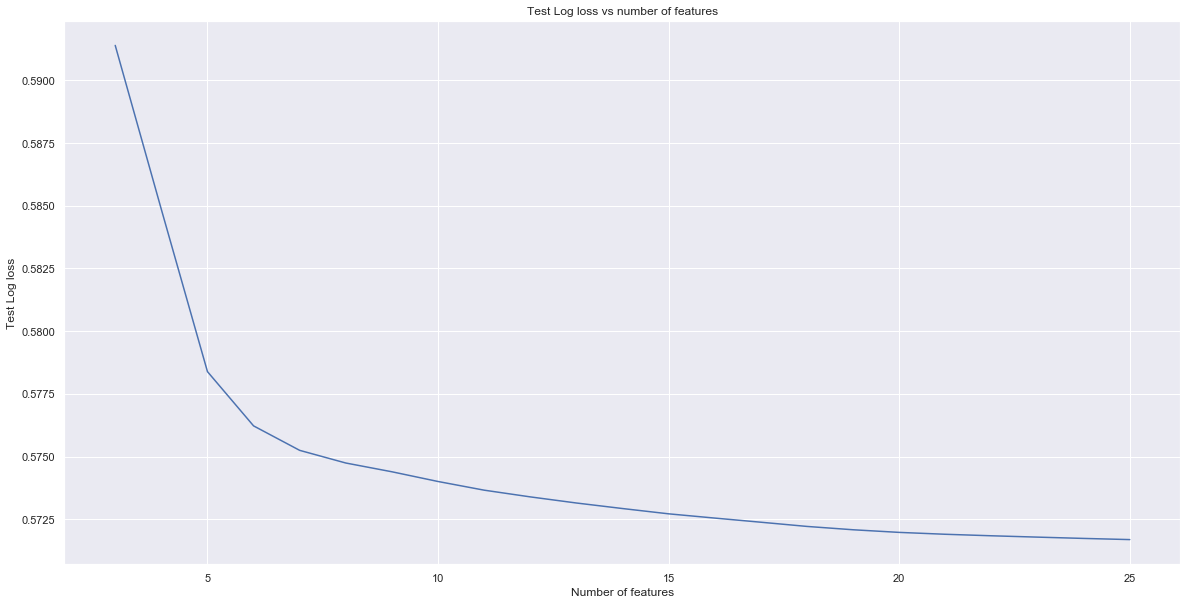

In [57]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(3,26), y=list(dict_ll.values())[2:])
plt.xlabel("Number of features")
plt.ylabel("Test Log loss")
plt.title("Test Log loss vs number of features")

In [58]:
chosen_features = list(list(dict_ll.items())[9][0])

In [59]:
df_train[chosen_features].corr()

,Credit Score_0.0,Credit Score_1.0,Current Loan Amount_4.0,Term_Short Term,no_credit_score,Home Ownership_Rent,Years in current job_0,Purpose_small_business,Number of Open Accounts_0,Years of Credit History_1.0
Credit Score_0.0,1.000000,-0.361667,0.034244,0.024593,0.114851,-0.006494,-0.011643,-0.005958,0.004697,-0.001228
Credit Score_1.0,-0.361667,1.000000,0.022797,0.052943,-0.041538,-0.027022,-0.000895,-0.002324,-0.000092,-0.020646
Current Loan Amount_4.0,0.034244,0.022797,1.000000,-0.021844,-0.120509,-0.014154,-0.019589,-0.006500,-0.027026,-0.023853
Term_Short Term,0.024593,0.052943,-0.021844,1.000000,0.036151,0.109770,0.053548,-0.000147,0.072230,0.057058
no_credit_score,0.114851,-0.041538,-0.120509,0.036151,1.000000,0.001037,0.000167,-0.002490,0.000472,-0.000048
Home Ownership_Rent,-0.006494,-0.027022,-0.014154,0.109770,0.001037,1.000000,-0.024814,0.005562,0.133486,0.180477
Years in current job_0,-0.011643,-0.000895,-0.019589,0.053548,0.000167,-0.024814,1.000000,-0.006504,0.046773,-0.051139
Purpose_small_business,-0.005958,-0.002324,-0.006500,-0.000147,-0.002490,0.005562,-0.006504,1.000000,0.020366,0.008159
Number of Open Accounts_0,0.004697,-0.000092,-0.027026,0.072230,0.000472,0.133486,0.046773,0.020366,1.000000,0.087195
Years of Credit History_1.0,-0.001228,-0.020646,-0.023853,0.057058,-0.000048,0.180477,-0.051139,0.008159,0.087195,1.000000


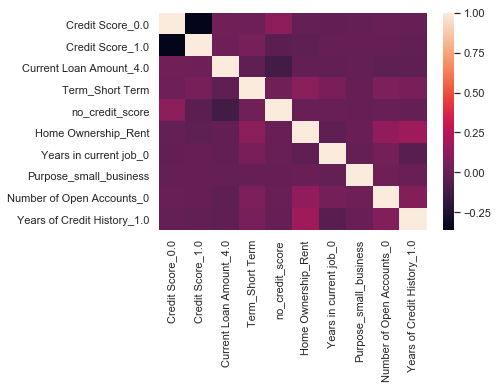

In [60]:
sns.heatmap(df_train[chosen_features].corr())

In [61]:
best_feat_train = df_train[chosen_features]
best_feat_test = df_test[chosen_features]

In [62]:
cols_to_use = best_feat_train.columns.tolist()

In [63]:
for col1 in tqdm(cols_to_use):
    cols_to_use.remove(col1)
    for col2 in cols_to_use:
        df_train[col1 + col2 + "prod"] = df_train[col1] * df_train[col2]
        df_test[col1 + col2 + "prod"] = df_test[col1] * df_test[col2]
        df_train[col1 + col2 + "sum"] = df_train[col1] * df_train[col2]
        df_test[col1 + col2 + "sum"] = df_test[col1] + df_test[col2]





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.01it/s]



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00, 21.24it/s]

In [64]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

(10000, 291)

In [65]:
for col in df_train.columns:
    if df_train[col].nunique() < 2:
        df_train.drop(col, axis=1, inplace=True)

for col in df_test.columns:
    if df_test[col].nunique() < 2:
        df_test.drop(col, axis=1, inplace=True)

In [66]:
common_cols = [col for col in df_train.columns if col in df_test.columns]

In [67]:
df_train = df_train[common_cols]
df_test = df_test[common_cols]

In [68]:
for col in common_cols:
    max = df_train[col].max()
    min = df_train[col].min()
    df_train[col] = (df_train[col] - min) / (max - min)
    
    max = df_test[col].max()
    min = df_test[col].min()
    df_test[col] = (df_test[col] - min) / (max - min)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, random_state=1)

In [73]:
all_cols = df_train.columns

best_cols = []

model = LogisticRegression(class_weight="balanced", solver="liblinear")

__Отберем 20 признаков__

In [75]:
dict_ll = {}

for _ in tqdm(range(20)):
    dict_ll_aux = {}
    for feat in all_cols:
        if feat not in best_cols:
            best_cols.append(feat)
            if len(best_cols) == 1:
                model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                y_pred = model.predict_proba(np.array(X_test[best_cols]).reshape(-1,1))[:, 1]
            else:
                model.fit(X_train[best_cols], y_train)
                y_pred = model.predict_proba(X_test[best_cols])[:, 1]
            best_cols.pop()
            dict_ll_aux[feat] = log_loss(y_test, y_pred)
    best_col, best_ll = sorted(dict_ll_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_ll[tuple(best_cols)] = best_ll






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]




  5%|████▏                                                                              | 1/20 [00:13<04:11, 13.23s/it]




 10%|████████▎                                                                          | 2/20 [00:38<05:00, 16.71s/it]




 15%|████████████▍                                                                      | 3/20 [01:06<05:42, 20.17s/it]




 20%|████████████████▌                                                                  | 4/20 [01:39<06:25, 24.10s/it]




 25%|████████████████████▊                                                              | 5/20 [02:18<07:10, 28.67s/it]




 30%|████████████████████████▉                                                          | 6/20 [03:04<07:52, 33.73s/it]




 35%|█████████████████████████████                                                      | 7/20 [04:00<08:47, 40.56s/it]




 40

Text(0.5, 1.0, 'Test log loss vs number of features')

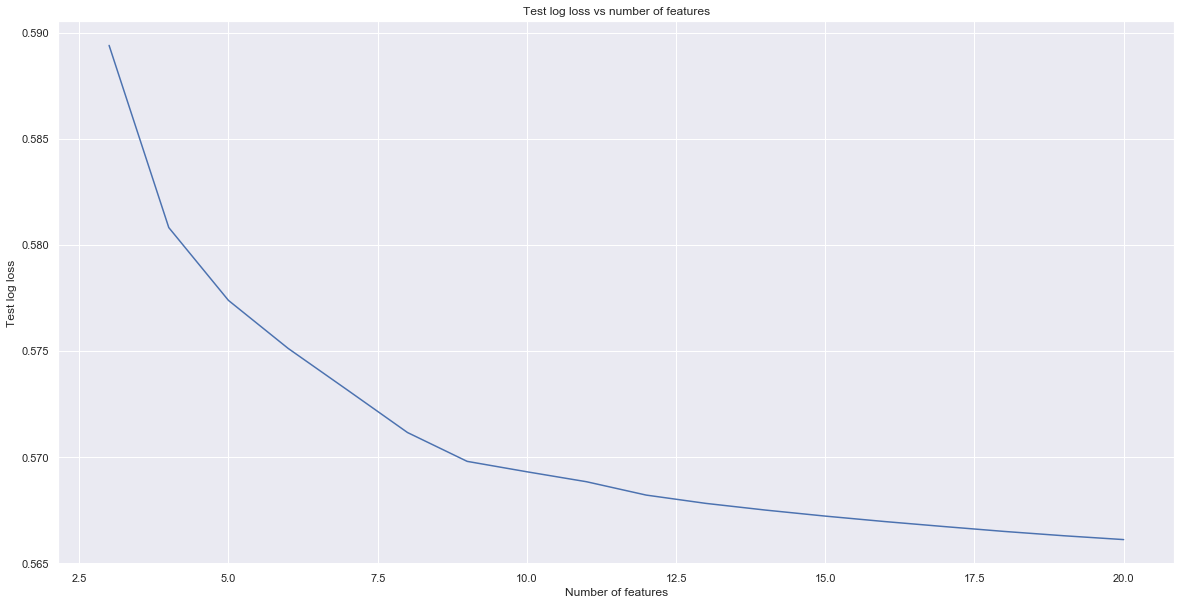

In [76]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(3,21), y=list(dict_ll.values())[2:])
plt.xlabel("Number of features")
plt.ylabel("Test log loss")
plt.title("Test log loss vs number of features")

In [77]:
chosen_features = list(list(dict_ll.items())[14][0])

In [78]:
df_train[chosen_features].corr()

,Current Loan Amount_4.0Years of Credit History_1.0sum,Credit Score_9.0,Credit Score_8.0,Current Loan Amount_4.0Term_Short Termprod,no_credit_score,Term_Short Term,Credit Score_0.0Home Ownership_Rentprod,Current Loan Amount_4.0,Current Loan Amount_4.0no_credit_scoreprod,Credit Score_0.0Years in current job_0prod,Purpose_small_business,Credit Score_1.0,Credit Score_0.0,Purpose_Buy a Car,Current Loan Amount_2.0,Number of Open Accounts_0Term_Short Termprod
Current Loan Amount_4.0Years of Credit History_1.0sum,1.000000,-0.014799,-0.002928,0.338556,-0.049642,-0.005574,0.062442,0.415744,0.120825,-0.026872,-0.000017,-0.006428,0.016551,-0.000688,-0.106881,0.005391
Credit Score_9.0,-0.014799,1.000000,-0.015752,-0.041555,-0.098356,-0.014685,-0.164635,-0.041621,-0.031936,-0.040962,0.002810,-0.017244,-0.856375,-0.003054,0.011638,-0.006890
Credit Score_8.0,-0.002928,-0.015752,1.000000,-0.030580,-0.037943,-0.090215,-0.063512,-0.019253,-0.012320,-0.015802,0.010424,-0.006652,-0.330368,-0.005359,-0.017336,-0.023783
Current Loan Amount_4.0Term_Short Termprod,0.338556,-0.041555,-0.030580,1.000000,-0.102837,0.273948,0.017574,0.804111,0.216285,-0.003201,-0.005694,0.041854,0.030821,-0.005184,-0.206725,0.046343
no_credit_score,-0.049642,-0.098356,-0.037943,-0.102837,1.000000,0.036151,0.023878,-0.120509,0.324702,0.007047,-0.002490,-0.041538,0.114851,-0.000295,0.046304,0.007028
Term_Short Term,-0.005574,-0.014685,-0.090215,0.273948,0.036151,1.000000,0.111328,-0.021844,-0.018778,0.052502,-0.000147,0.052943,0.024593,0.011898,0.186965,0.299474
Credit Score_0.0Home Ownership_Rentprod,0.062442,-0.164635,-0.063512,0.017574,0.023878,0.111328,1.000000,-0.004827,-0.003349,-0.016333,0.003879,-0.069529,0.192246,0.010653,0.060026,0.137201
Current Loan Amount_4.0,0.415744,-0.041621,-0.019253,0.804111,-0.120509,-0.021844,-0.004827,1.000000,0.287806,-0.016979,-0.006500,0.022797,0.034244,-0.008078,-0.257085,-0.037807
Current Loan Amount_4.0no_credit_scoreprod,0.120825,-0.031936,-0.012320,0.216285,0.324702,-0.018778,-0.003349,0.287806,1.000000,-0.006058,-0.002316,-0.013487,0.037292,-0.008024,-0.073991,-0.019969
Credit Score_0.0Years in current job_0prod,-0.026872,-0.040962,-0.015802,-0.003201,0.007047,0.052502,-0.016333,-0.016979,-0.006058,1.000000,-0.006932,-0.017299,0.047831,0.000032,0.011696,0.056029


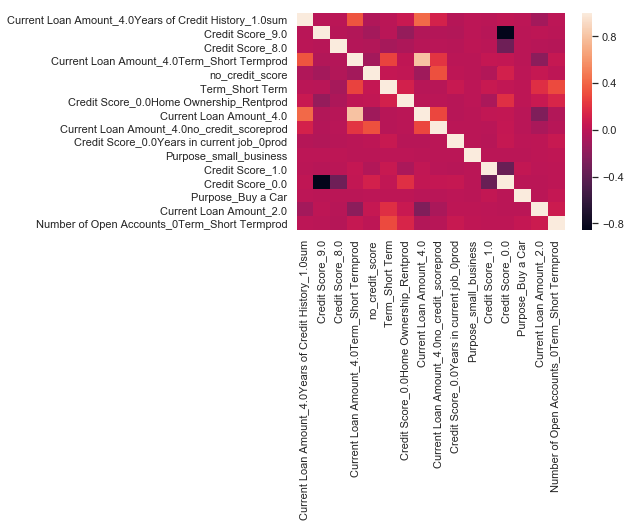

In [79]:
sns.heatmap(df_train[chosen_features].corr())

In [80]:
chosen_features.remove("Credit Score_9.0")

In [82]:
chosen_features.remove("Current Loan Amount_4.0Term_Short Termprod")

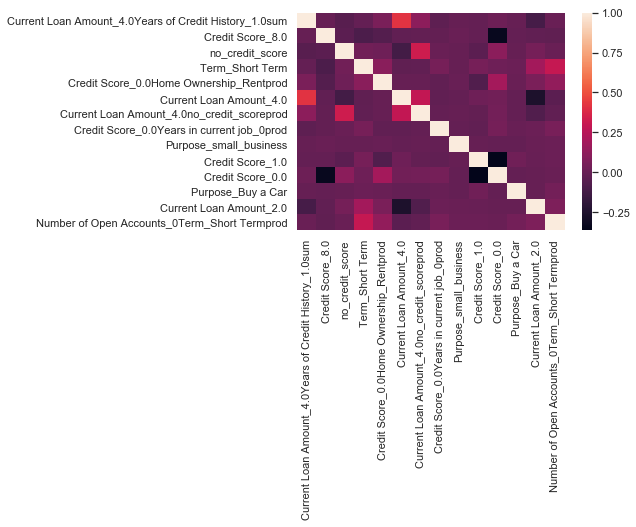

In [83]:
sns.heatmap(df_train[chosen_features].corr())

In [84]:
chosen_features

['Current Loan Amount_4.0Years of Credit History_1.0sum',
 'Credit Score_8.0',
 'no_credit_score',
 'Term_Short Term',
 'Credit Score_0.0Home Ownership_Rentprod',
 'Current Loan Amount_4.0',
 'Current Loan Amount_4.0no_credit_scoreprod',
 'Credit Score_0.0Years in current job_0prod',
 'Purpose_small_business',
 'Credit Score_1.0',
 'Credit Score_0.0',
 'Purpose_Buy a Car',
 'Current Loan Amount_2.0',
 'Number of Open Accounts_0Term_Short Termprod']

In [ ]:
"Current Loan Amount_4.0Years of Credit History_1.0sum"

In [85]:
best_train = df_train[chosen_features]
best_test = df_test[chosen_features]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(best_train, y, test_size=0.25, random_state=4)

In [87]:
model = LogisticRegression(class_weight="balanced", solver="liblinear")

In [88]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc_train = roc_auc_score(y_train, model.predict(X_train))
auc_test = roc_auc_score(y_test, y_pred)

print("Accuracy: {}\nAUC train: {}\nAUC test: {}\nPrecision: {}\nRecall: {}".format(acc, auc_train, auc_test, prec, rec))

Accuracy: 0.68848
AUC train: 0.6491248950490535
AUC test: 0.6479312590463397
Precision: 0.37982608695652176
Recall: 0.573228346456693


__Можно заметить, что precision имеет высокое значение, а recall - низкое.__

__Это означает, что модель редко совершает ошибку первого рода (ложно классифицирует хорошего заемщика как плохого), но часто совершает ошибку второго рода (ложно классифицирует плохого заемщика как хорошего).__

__Попробуем откалбировать порог.__

In [107]:
df_thr = pd.DataFrame(columns=["thresh", "accuracy"], index=range(100))

In [108]:
for num, i in enumerate(range(1, 100)):
    thr = i/100
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))
    y_pred = y_pred >= thr
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df_thr.loc[num, "thresh"] = thr
    df_thr.loc[num, "accuracy"] = acc
    print("Threshold={}\nAccuracy: {}\nAUC: {}\nPrecision: {}\nRecall: {}\n".format(thr, acc, auc, prec, rec))

Threshold=0.01
Accuracy: 0.22876
AUC: 0.5001037075447239
Precision: 0.2286365818530965
Recall: 1.0

Threshold=0.02
Accuracy: 0.22876
AUC: 0.5001037075447239
Precision: 0.2286365818530965
Recall: 1.0

Threshold=0.03
Accuracy: 0.22932
AUC: 0.5004666839512575
Precision: 0.22876471059162598
Recall: 1.0

Threshold=0.04
Accuracy: 0.2312
AUC: 0.501685247601763
Precision: 0.2291959093643473
Recall: 1.0

Threshold=0.05
Accuracy: 0.23132
AUC: 0.5017630282603059
Precision: 0.2292234878870528
Recall: 1.0

Threshold=0.06
Accuracy: 0.23144
AUC: 0.5018408089188489
Precision: 0.22925107304745476
Recall: 1.0

Threshold=0.07
Accuracy: 0.23144
AUC: 0.5017792467411628
Precision: 0.2292293497011273
Recall: 0.999825021872266

Threshold=0.08
Accuracy: 0.232
AUC: 0.5021422231476964
Precision: 0.22935816641913861
Recall: 0.999825021872266

Threshold=0.09
Accuracy: 0.23224
AUC: 0.5022977844647821
Precision: 0.22941341791464248
Recall: 0.999825021872266

Threshold=0.1
Accuracy: 0.23252
AUC: 0.5024792726680489
Pr

In [92]:
df_thr.sort_values(by="accuracy", ascending=False)

,thresh,accuracy
77,0.78,0.82028
78,0.79,0.82028
75,0.76,0.82024
76,0.77,0.8202
86,0.87,0.8202
87,0.88,0.82016
70,0.71,0.82016
74,0.75,0.82016
79,0.8,0.82016
80,0.81,0.82016


In [97]:
model.fit(best_train, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
best_thresh = [0.75, 0.8, 0.85, 0.9]

In [99]:
for thr in best_thresh:
    ac = accuracy_score(y, model.predict_proba(best_train)[:, 1:] >=thr)
    print(thr, ac)

0.75 0.81913
0.8 0.81929
0.85 0.81918
0.9 0.81912


In [100]:
preds = model.predict_proba(best_test)[:, 1:]

In [101]:
preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

In [102]:
preds1 = preds >= 0.75
preds2 = preds >= 0.8
preds3 = preds >= 0.85
preds4 = preds >= 0.9

In [103]:
sub1 = pd.read_csv('credit__sample.csv')
sub2 = pd.read_csv('credit__sample.csv')
sub3 = pd.read_csv('credit__sample.csv')
sub4 = pd.read_csv('credit__sample.csv')

In [104]:
sub1["Loan Status"] = preds1
sub2["Loan Status"] = preds2
sub3["Loan Status"] = preds3
sub4["Loan Status"] = preds4

In [105]:
sub1["Loan Status"] = sub1["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub2["Loan Status"] = sub2["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub3["Loan Status"] = sub3["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub4["Loan Status"] = sub4["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")

In [106]:
sub1.to_csv("sub1_1104_logreg.csv", index=None)
sub2.to_csv("sub2_1104_logreg.csv", index=None)
sub3.to_csv("sub3_1104_logreg.csv", index=None)
sub4.to_csv("sub4_1104_logreg.csv", index=None)

In [110]:
sub1["Loan Status"].value_counts()[0],sub2["Loan Status"].value_counts()[0],sub3["Loan Status"].value_counts()[0]

(9535, 9541, 9545)

In [7]:
df_sub = pd.read_csv('credit__sample.csv')

In [9]:
df_sub["Loan Status"] = "Fully Paid"

In [10]:
df_sub.to_csv("sub1_stupid_0.csv", index=None)

In [111]:
model = LogisticRegression(solver="liblinear")

In [112]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc_train = roc_auc_score(y_train, model.predict(X_train))
auc_test = roc_auc_score(y_test, y_pred)

print("Accuracy: {}\nAUC train: {}\nAUC test: {}\nPrecision: {}\nRecall: {}".format(acc, auc_train, auc_test, prec, rec))

Accuracy: 0.82012
AUC train: 0.5994114973901385
AUC test: 0.6069926150338286
Precision: 0.9943181818181818
Recall: 0.21434820647419073


__Можно заметить, что precision имеет высокое значение, а recall - низкое.__

__Это означает, что модель редко совершает ошибку первого рода (ложно классифицирует хорошего заемщика как плохого), но часто совершает ошибку второго рода (ложно классифицирует плохого заемщика как хорошего).__

__Попробуем откалбировать порог.__

In [113]:
df_thr2 = pd.DataFrame(columns=["thresh", "accuracy"], index=range(100))

In [114]:
for num, i in enumerate(range(1, 100)):
    thr = i/100
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))
    y_pred = y_pred >= thr
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df_thr2.loc[num, "thresh"] = thr
    df_thr2.loc[num, "accuracy"] = acc
    print("Threshold={}\nAccuracy: {}\nAUC: {}\nPrecision: {}\nRecall: {}\n".format(thr, acc, auc, prec, rec))

Threshold=0.01
Accuracy: 0.22932
AUC: 0.5004666839512575
Precision: 0.22876471059162598
Recall: 1.0

Threshold=0.02
Accuracy: 0.23144
AUC: 0.5018408089188489
Precision: 0.22925107304745476
Recall: 1.0

Threshold=0.03
Accuracy: 0.232
AUC: 0.5021422231476964
Precision: 0.22935816641913861
Recall: 0.999825021872266

Threshold=0.04
Accuracy: 0.24228
AUC: 0.5081898111193451
Precision: 0.2315310927098555
Recall: 0.9980752405949256

Threshold=0.05
Accuracy: 0.28916
AUC: 0.533958958396988
Precision: 0.24144290983958136
Recall: 0.9849518810148732

Threshold=0.06
Accuracy: 0.31144
AUC: 0.5454452494708579
Precision: 0.24628215877498785
Recall: 0.9765529308836396

Threshold=0.07
Accuracy: 0.33776
AUC: 0.5584420368506569
Precision: 0.2521603950436651
Recall: 0.9650043744531933

Threshold=0.08
Accuracy: 0.34492
AUC: 0.5619748302787015
Precision: 0.2538326560768378
Recall: 0.9618547681539807

Threshold=0.09
Accuracy: 0.3784
AUC: 0.576842232289022
Precision: 0.26149439238724087
Recall: 0.9424321959755

In [115]:
df_thr2.sort_values(by="accuracy", ascending=False)

,thresh,accuracy
53,0.54,0.82028
52,0.53,0.82028
49,0.5,0.8202
68,0.69,0.8202
51,0.52,0.8202
50,0.51,0.8202
67,0.68,0.8202
92,0.93,0.82016
42,0.43,0.82016
71,0.72,0.82016


In [146]:
model = LogisticRegression(solver="liblinear")

In [148]:
model.fit(best_train, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [149]:
preds = model.predict_proba(best_test)[:, 1:]

In [117]:
preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

In [123]:
preds5 = preds >= 0.53
preds6 = preds >= 0.54
preds7 = preds >= 0.45
preds8 = preds >= 0.6

In [124]:
sub5 = pd.read_csv('credit__sample.csv')
sub6 = pd.read_csv('credit__sample.csv')
sub7 = pd.read_csv('credit__sample.csv')
sub8 = pd.read_csv('credit__sample.csv')

In [125]:
sub5["Loan Status"] = preds5
sub6["Loan Status"] = preds6
sub7["Loan Status"] = preds7
sub8["Loan Status"] = preds8

In [126]:
sub5["Loan Status"] = sub5["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub6["Loan Status"] = sub6["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub7["Loan Status"] = sub7["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")
sub8["Loan Status"] = sub8["Loan Status"].apply(lambda x: "Fully Paid" if x == 0 else "Charged Off")

In [127]:
sub5.to_csv("sub5_1104_logreg.csv", index=None)
sub6.to_csv("sub6_1104_logreg.csv", index=None)
sub7.to_csv("sub7_1104_logreg.csv", index=None)
sub8.to_csv("sub8_1104_logreg.csv", index=None)

In [150]:
best_thresh = [0.45, 0.53, 0.54, 0.6]

In [151]:
for thr in best_thresh:
    ac = accuracy_score(y, model.predict_proba(best_train)[:, 1:] >=thr)
    print(thr, ac)

0.45 0.81881
0.53 0.8193
0.54 0.81929
0.6 0.8192


In [139]:
mod_stupid = RandomForestClassifier(random_state=4, n_estimators=10)

In [140]:
mod_stupid.fit(X_train, y_train)
y_pred = mod_stupid.predict(X_test)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc_train = roc_auc_score(y_train, mod_stupid.predict(X_train))
auc_test = roc_auc_score(y_test, y_pred)

print("Accuracy: {}\nAUC train: {}\nAUC test: {}\nPrecision: {}\nRecall: {}".format(acc, auc_train, auc_test, prec, rec))

Accuracy: 0.82012
AUC train: 0.6001612403206523
AUC test: 0.6075466746330029
Precision: 0.9872
Recall: 0.215923009623797


In [141]:
df_thr3 = pd.DataFrame(columns=["thresh", "accuracy"], index=range(100))

In [144]:
for num, i in enumerate(range(1, 100)):
    thr = i/100
    y_pred = mod_stupid.predict_proba(X_test)[:, 1]
    y_pred = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))
    y_pred = y_pred >= thr
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df_thr3.loc[num, "thresh"] = thr
    df_thr3.loc[num, "accuracy"] = acc
    print("Threshold={}\nAccuracy: {}\nAUC: {}\nPrecision: {}\nRecall: {}\n".format(thr, acc, auc, prec, rec))

Threshold=0.01
Accuracy: 0.23212
AUC: 0.501850630740123
Precision: 0.22925536187645593
Recall: 0.9987751531058617

Threshold=0.02
Accuracy: 0.23276
AUC: 0.5020807743859603
Precision: 0.22933751406978614
Recall: 0.9982502187226596

Threshold=0.03
Accuracy: 0.23452
AUC: 0.5032215573779231
Precision: 0.22974387886597938
Recall: 0.9982502187226596

Threshold=0.04
Accuracy: 0.2442
AUC: 0.5088802420568572
Precision: 0.2317867317867318
Recall: 0.9965004374453194

Threshold=0.05
Accuracy: 0.24568
AUC: 0.509593288134809
Precision: 0.23204892966360857
Recall: 0.9958005249343832

Threshold=0.06
Accuracy: 0.30556
AUC: 0.5417571215576273
Precision: 0.2447396107311941
Recall: 0.9769028871391076

Threshold=0.07
Accuracy: 0.30556
AUC: 0.5417571215576273
Precision: 0.2447396107311941
Recall: 0.9769028871391076

Threshold=0.08
Accuracy: 0.3438
AUC: 0.5613104396433205
Precision: 0.253527621506963
Recall: 0.9620297462817148

Threshold=0.09
Accuracy: 0.34384
AUC: 0.5613363665295015
Precision: 0.25353931288

In [145]:
df_thr3.sort_values(by="accuracy", ascending=False)

,thresh,accuracy
59,0.6,0.8204
47,0.48,0.8204
60,0.61,0.8204
58,0.59,0.82036
76,0.77,0.82032
46,0.47,0.82032
66,0.67,0.82028
75,0.76,0.82028
65,0.66,0.82028
63,0.64,0.82028
